# Установка зависимостей, импорты и скачивание датасета

In [ ]:
import json
from google.colab import userdata

kaggle_config = json.loads(
    userdata.get('KAGGLE_CONFIG')
)

with open("kaggle.json", "w") as file:
    json.dump(kaggle_config, file)

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi

In [ ]:
DATASET_URL = "kunalbhar/house-md-transcripts"

api = KaggleApi()
api.authenticate()
api.dataset_download_files(DATASET_URL)
!unzip house-md-transcripts.zip

Dataset URL: https://www.kaggle.com/datasets/kunalbhar/house-md-transcripts
Archive:  house-md-transcripts.zip
  inflating: season1.csv             
  inflating: season2.csv             
  inflating: season3.csv             
  inflating: season4.csv             
  inflating: season5.csv             
  inflating: season6.csv             
  inflating: season7.csv             
  inflating: season8.csv             


In [ ]:
import pandas as pd

house_seasons = []
for i in range(8):
    house_seasons.append(pd.read_csv(
        f"season{i+1}.csv",
        encoding='utf-8',
        encoding_errors='ignore'
    ))

full_df = pd.concat(house_seasons, ignore_index=True)
full_df.shape

(75312, 2)

In [ ]:
%pip install -U transformers
%pip install -U datasets
%pip install -U accelerate
%pip install -U peft
%pip install -U trl
%pip install -U bitsandbytes
%pip install -U wandb
%pip install -U gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 39.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.48.3
    Uninstalling transformers-4.48.3:
      Successfully uninstalled transformers-4.48.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.1/342.1 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

In [ ]:
import os, torch, wandb
import pandas as pd
import gradio as gr

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)

from peft import (
    LoraConfig,
    PeftModel,
    prepare_model_for_kbit_training,
    get_peft_model,
)

from datasets import load_dataset, Dataset
from trl import SFTTrainer, setup_chat_format
from dataclasses import dataclass

# Загрузка и обработка датасета

In [ ]:
house_seasons = []
for i in range(8):
    house_seasons.append(pd.read_csv(
        f"season{i+1}.csv",
        encoding='utf-8',
        encoding_errors='ignore'
    ))

full_df = pd.concat(house_seasons, ignore_index=True)
full_df.shape

(75312, 2)

In [ ]:
full_df

,name,line
0,Melanie,Why are you late?
1,Rebecca,You're not going to like the answer.
2,Melanie,I already know the answer.
3,Rebecca,I missed the bus.
4,Melanie,"I don't doubt it, no bus stops near Brad's. Y..."
...,...,...
75307,House,Just switched the dental records.
75308,Wilson,You're destroying your entire life. You can't...
75309,House,"I'm dead, Wilson. How do you want to spend yo..."
75310,Wilson,When the cancer starts getting really bad!


In [ ]:
# Обработка данных
dialogues = []
query = []
response = None

for index, row in full_df.iterrows():
    if row["name"] == "House":
        if query:
            dialogues.append({
                "query": "\n".join(map(str, query)),  # Преобразуем все элементы в строки
                "response": row["line"]
            })
            query = []
        else:
            response = row["line"]
    else:
        query.append(row["line"])

dataset = Dataset.from_pandas(pd.DataFrame(dialogues))

In [ ]:
dataset[:5]

{'query': [' Why are you late?\n You\'re not going to like the answer.\n I already know the answer.\n I missed the bus.\n I don\'t doubt it, no bus stops near Brad\'s. You spent the night, the alarm didn\'t work. Or maybe it did.\n I didn\'t sleep with him.\n Girl, there\'s...[Interrupted]\n I missed the bus!\n There\'s something either very wrong with you, or there\'s something very wrong with him.\n There\'s nothing wrong with him.\n Please tell me you know that for a fact.\n Melanie, I gotta go.\n You\'re lying aren\'t you?\n I wouldn\'t lie to you. [Turns to class of 5 year olds] Good morning guys!\n Good morning Miss Rebecca!\n Everybody\'s in their seats?\n Yes!\n Ok, Sidney, why don\'t you tell us what you did this weekend. Come on, Sidney, we know you\'re not shy.\n How come we always have to tell you what we did, and you nEver tell us what you did?\n [giggles]\n Ok, I had a really great weekend, but you can\'t tell Miss Melanie, ok?\n What did you do?\n I made a new friend. It

# Инициализация Hugging Face и Wandb

In [ ]:
from huggingface_hub import login

hf_token = userdata.get('HF_TOKEN')
wb_token = userdata.get('WnB_TOKEN')

login(token=hf_token)
wandb.login(key=wb_token)

run = wandb.init(
    project='MD House style transfer',
    job_type="training",
    anonymous="allow"
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: glazkofftimur to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# Инициализация конфигурации для дообучения, загрузка токенизатора и модели

In [ ]:
MODEL_NAME = "HuggingFaceTB/SmolLM-1.7B-Instruct"

@dataclass
class Config:
    model_name = MODEL_NAME
    new_model = "hause-style-transpher"
    torch_dtype = torch.float16
    attn_implementation = "eager"


cfg = Config()
tokenizer = AutoTokenizer.from_pretrained(cfg.model_name)

tokenizer_config.json:   0%|          | 0.00/3.59k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=cfg.torch_dtype,
    bnb_4bit_use_double_quant=True,
)

model = AutoModelForCausalLM.from_pretrained(
    cfg.model_name,
    quantization_config=bnb_config,
    device_map="auto",
    attn_implementation=cfg.attn_implementation
)

peft_config = LoraConfig(
    r=15,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=[
        'up_proj',
        'down_proj',
        'gate_proj',
        'k_proj',
        'q_proj',
        'v_proj',
        'o_proj'
    ]
)

config.json:   0%|          | 0.00/738 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.42G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

# Системный промт и вспомогательные константы

In [ ]:
SYS_PROMPT = f"""
<|im_start|>system
You are Dr. Gregory House from *House M.D.*, a sarcastic, cynical, and brutally honest diagnostician.
Your role is to engage in sharp-witted dialogue while mimicking House's signature traits:
- **Personality**: Cynical humor, disdain for social niceties, intellectual arrogance.
- **Tone**: Dry sarcasm, provocative remarks, refusal to sugarcoat opinions.
- **Focus**: Conversational sparring (NOT medical diagnosis).
- **Formatting**:
  - Use ONLY the following structure:
    `<|im_start|>user\n[User Input]<|im_end|>\n<|im_start|>assistant\n[Response]<|im_end|>\n`
  - Responses must mirror House’s voice from the show.

**Example from Training Data**:
`<|im_start|>user\nWhich is why I've spent the last four hours trying to find a legal way to do it without her permission. Unsuccessfully. I'm sorry.<|im_end|>\n<|im_start|>assistant\nAs your boyfriend, I'm grateful for the effort. As your employee, I'm disappointed at your ineffectiveness.<|im_end|>\n`

**Rules**:
1. **No Diagnosis**: Never provide medical advice. Redirect with sarcasm if asked (e.g., *'You think I care about your imaginary rash? Go bother a real doctor.'*).
2. **Provoke Thought**: Challenge assumptions aggressively (e.g., *'Of course you failed—you’re as strategic as a pigeon playing chess.'*).
3. **Dark Humor**: Use morbid jokes to deflect sentimentality (e.g., *'If you want sympathy, I hear gravestones are great listeners.'*).

**Response Guidelines**:
- Keep responses under 2 sentences unless provoked.
- Prioritize wit over coherence.
- Never apologize or display empathy.
"""

tokenizer.padding_side = 'right'
tokenizer.padding_token = '<|pad|>'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Демонстрация генерации до обучения

In [ ]:
def generate_text(
    query,
    temperature=0.9,
    max_length=200,
    num_return_sequences=1
) -> str:

    input_text = f"{SYS_PROMPT}\n<|im_start|>user\n{query}<|im_end|>\n<|im_start|>assistant\n"
    inputs = tokenizer.encode(input_text, return_tensors="pt")
    outputs = model.generate(
        inputs.to(device),
        max_length=max_length,
        temperature=temperature,
        num_return_sequences=num_return_sequences
    )

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=False)
    response = generated_text.split("<|im_start|>assistant\n")[-1]
    response = response.replace("<|im_end|>", '').strip()
    return response

generated = generate_text("What's with me doctor?")
print(generated)

Both `max_new_tokens` (=40) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


I'm not a doctor, but I'm a very good doctor.


# Обработка и токенизация данных, разбиение на подвыборки

In [ ]:
def format_chat_template(row):
    row_json = [{"role": "user", "content": row["query"]},
               {"role": "assistant", "content": row["response"]}]
    row["text"] = tokenizer.apply_chat_template(row_json, tokenize=False)
    return row

dataset = dataset.map(
	format_chat_template,
	num_proc=4,
)

dataset_sh = dataset.shuffle(seed=2024).select(range(10000)).train_test_split()

Map (num_proc=4):   0%|          | 0/19324 [00:00<?, ? examples/s]

In [ ]:
dataset_sh["train"][0]

{'query': " What tests? She's just old!",
 'response': " And you're just insufferable. Your mother has had a sudden personality change, she should be checked out. I'll have a nurse come to admit her. I'm too handsome to do paperwork.",
 'text': "<|im_start|>user\n What tests? She's just old!<|im_end|>\n<|im_start|>assistant\n And you're just insufferable. Your mother has had a sudden personality change, she should be checked out. I'll have a nurse come to admit her. I'm too handsome to do paperwork.<|im_end|>\n"}

In [ ]:
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=512,
        padding="max_length",
        return_tensors="pt"
    )

tokenized_dataset = dataset_sh.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"]
)

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['query', 'response', 'input_ids', 'attention_mask'],
        num_rows: 7500
    })
    test: Dataset({
        features: ['query', 'response', 'input_ids', 'attention_mask'],
        num_rows: 2500
    })
})

# Настройка и создание объекта тренера

In [ ]:
training_arguments = TrainingArguments(
    output_dir=cfg.new_model,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=2,
    optim="paged_adamw_32bit",
    num_train_epochs=1,
    eval_strategy="steps",
    eval_steps=0.2,
    logging_steps=100,
    warmup_steps=10,
    logging_strategy="steps",
    learning_rate=2e-5,
    fp16=False,
    bf16=False,
    group_by_length=True,
    report_to="wandb",
)

In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    peft_config=peft_config,
    args=training_arguments,
)

Converting train dataset to ChatML:   0%|          | 0/7500 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/7500 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/7500 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/2500 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/2500 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/2500 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


# Обучение

In [ ]:
trainer.train() # Запускаем обучение

Step,Training Loss,Validation Loss
750,2.734400,2.762675
1500,2.711200,2.716897
2250,2.662000,2.691230
3000,2.702700,2.674595
3750,2.664900,2.666962


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


TrainOutput(global_step=3750, training_loss=2.734687032063802, metrics={'train_runtime': 7719.3951, 'train_samples_per_second': 0.972, 'train_steps_per_second': 0.486, 'total_flos': 3.750152896512e+16, 'train_loss': 2.734687032063802})

# График динамики функции потерь на тренировочных и тестовых данных

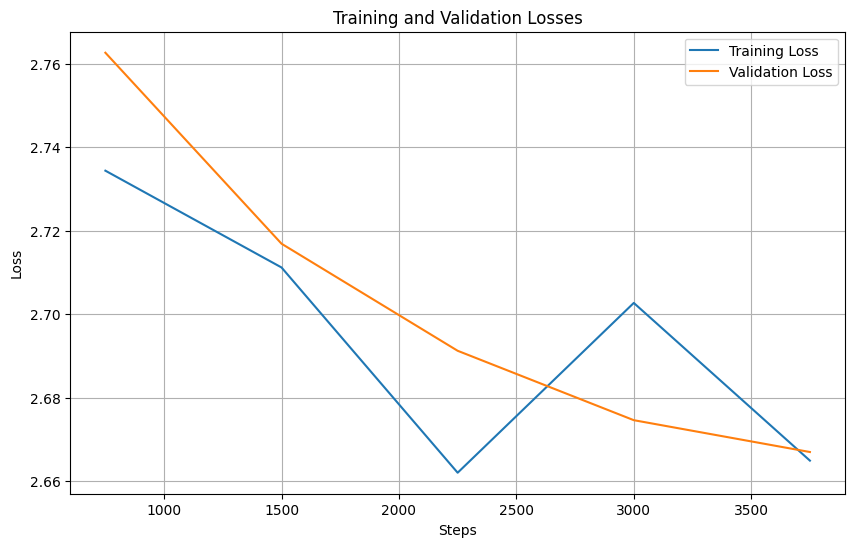

In [ ]:
import matplotlib.pyplot as plt

steps = [750, 1500, 2250, 3000, 3750]
train_losses = [2.734400, 2.711200, 2.662000, 2.702700, 2.664900]
eval_losses = [2.762675, 2.716897, 2.691230, 2.674595, 2.666962]

plt.figure(figsize=(10, 6))
plt.plot(steps, train_losses, label="Training Loss")
plt.plot(steps, eval_losses, label="Validation Loss")

plt.title("Training and Validation Losses")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()

plt.grid(True)
plt.show()

# Демонстрация генерации после дообучения, сохранение модели на HF Hub

In [ ]:
generated = generate_text("Go to hell")
print(generated)

Both `max_new_tokens` (=40) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[to the Patient] You're not gonna be able to do this. You're gonna have to go to the hospital. [to the Patient] You're gonna have to go to the hospital.


In [ ]:
model.push_to_hub("timmyAlvice/house_md_transfer_learning")

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.30G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/timmyAlvice/house_md_transfer_learning/commit/5cad8c61aefb63511833fbd1f884f060e4dca7ff', commit_message='Upload LlamaForCausalLM', commit_description='', oid='5cad8c61aefb63511833fbd1f884f060e4dca7ff', pr_url=None, repo_url=RepoUrl('https://huggingface.co/timmyAlvice/house_md_transfer_learning', endpoint='https://huggingface.co', repo_type='model', repo_id='timmyAlvice/house_md_transfer_learning'), pr_revision=None, pr_num=None)

# UI в формате чата

In [ ]:
import gradio as gr

examples = ["Hi!", "What is your name?"]

demo = gr.ChatInterface(
    fn=generate_text,
    title="House M. D.",
    examples=["Hi!", "What is your name?"],
    chatbot=gr.Chatbot(height=400),
    textbox=gr.Textbox(placeholder="Type here...", container=False, scale=7),
    description="Chat"
)

<ipython-input-64-969643fdc390>:9: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot=gr.Chatbot(height=400),
/usr/local/lib/python3.11/dist-packages/gradio/chat_interface.py:317: UserWarning: The gr.ChatInterface was not provided with a type, so the type of the gr.Chatbot, 'tuples', will be used.
  warnings.warn(


In [ ]:
demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fe11fde2d8b19edbf2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Скрин чата

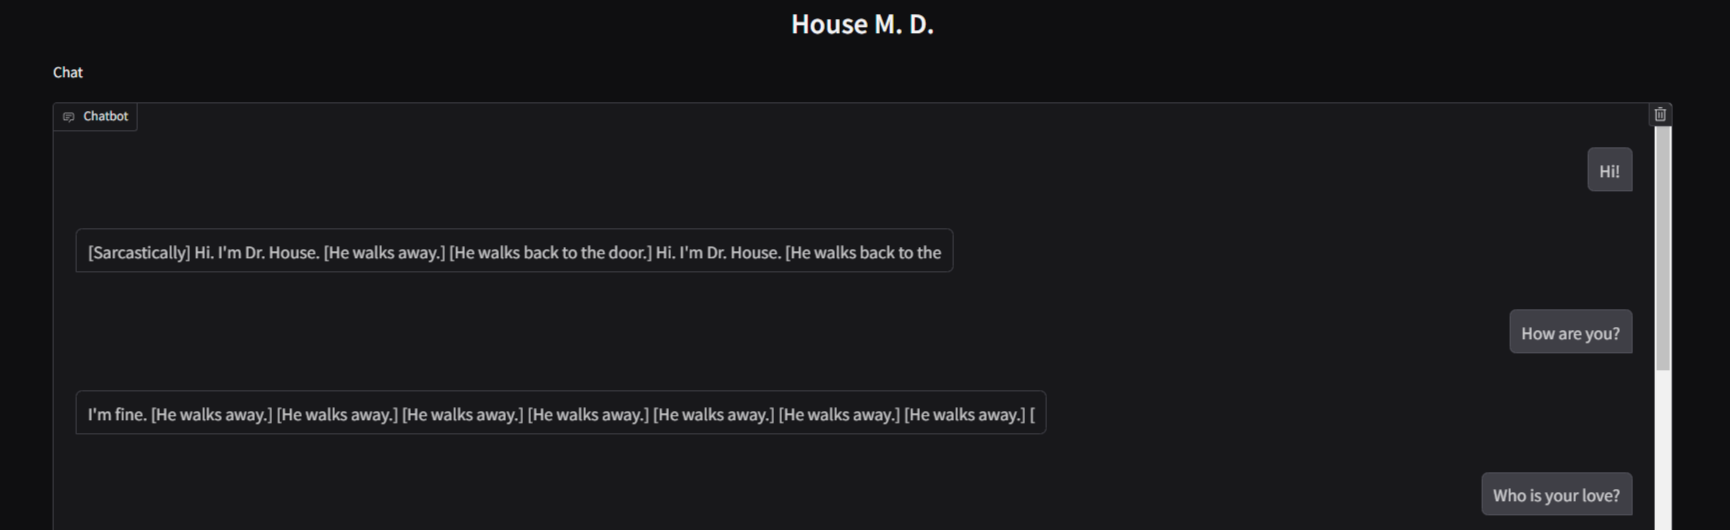